Processing the Adult Dataset using KNN
==

The objective of this notebook is to use the "***Adult***" dataset to create a classifier for the Target variable (that is, whether <=50k or >50k). The classifier must be a KNN so that the value of the quantity K is chosen through cross-validation.

The notebook is divided into two sections: The first is intended for carrying out exploratory analysis (getting to know and better understand the data) and data preparation and the second is dedicated to evaluating the impact of the selection of variables used to produce an empirical error rate.

We will start by importing the necessary modules:

In [ ]:
%pip install seaborn
%pip install missingno

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,precision_score,recall_score,f1_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

## 1. Exploratory Data Analysis(EDA)

We will indicate that the "Id" column will be the index of our DataFrame

In [2]:
df_train = pd.read_csv("/kaggle/input/adult-pmr3508/train_data.csv",
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")
df_test = pd.read_csv("/kaggle/input/adult-pmr3508/test_data.csv", index_col=['Id'], na_values="?")

Now, renaming the columns: removing white spaces, and replacing periods with '_' and changing to lower case.

In [3]:
df_train.columns= df_train.columns.str.strip().str.lower().str.replace('.','_')
df_test.columns= df_test.columns.str.strip().str.lower().str.replace('.','_')

In [4]:
display(df_train.head())
df_train.shape

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


(32560, 16)

Now, we will do a quick, high-level analysis of all the columns in our dataset.

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              32560 non-null  int64 
 1   age             32560 non-null  int64 
 2   workclass       30724 non-null  object
 3   fnlwgt          32560 non-null  int64 
 4   education       32560 non-null  object
 5   education_num   32560 non-null  int64 
 6   marital_status  32560 non-null  object
 7   occupation      30717 non-null  object
 8   relationship    32560 non-null  object
 9   race            32560 non-null  object
 10  sex             32560 non-null  object
 11  capital_gain    32560 non-null  int64 
 12  capital_loss    32560 non-null  int64 
 13  hours_per_week  32560 non-null  int64 
 14  native_country  31977 non-null  object
 15  income          32560 non-null  object
dtypes: int64(7), object(9)
memory usage: 4.0+ MB


It is evident that the dataset contains a total of 15 columns. Among these columns, one of them functions as an index (id), while another is designated as the target variable (income). The other columns are distributed into two distinct groups: numerical variables, which are characterized by numerical values, and categorical variables, which are characterized by a limited and countable number of categories.
Are they:

- Numerical variables: age, fnlwgt, education_num, capital_gain, capital_loss, hours_per_week.
- Categorical variables: workclass, sex, education, marital_status, occupation, relationship, race, sex, native_country

In [6]:
df_train.describe()

,id,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32560.000000,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,32559.500000,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,9399.406719,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,16280.000000,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,24419.750000,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,32559.500000,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,40699.250000,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,48839.000000,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


We have that the variable ***income***, the income of individuals, indicates whether the income is above or below a certain limit and is the variable we want to predict.

First, a general view of the arrangement of data in histogram charts

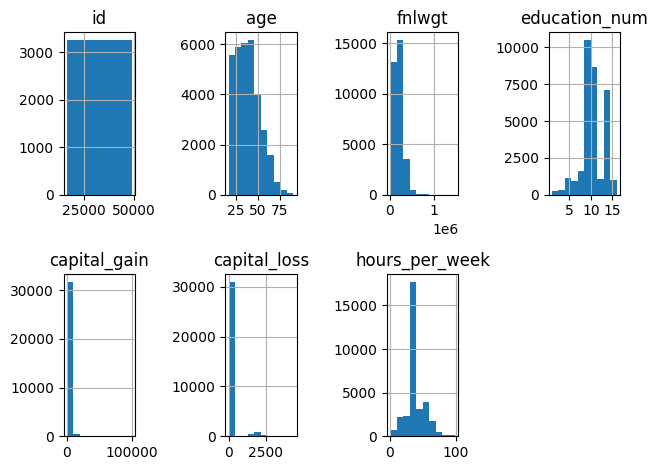

In [8]:
df_train.hist(layout=(2,4))
plt.tight_layout()
plt.show()

Now, let's create a copy of the DataFrame to be able to manipulate and visualize the data without altering the original dataset.

In [9]:
df_viz = df_train.copy()

Making a heatmap to observe possible correlations between variables

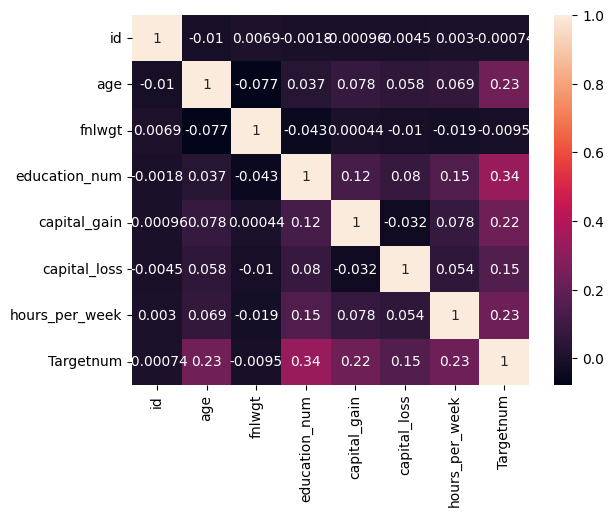

In [10]:
#transform the categorical variable "income" into a numeric variable. For this, let's assign values 1 for incomes greater than 50K and 0 for incomes less than 50K.
df_viz['Targetnum']=df_viz['income'].map({'<=50K': 0, '>50K': 1})

#Correlation heatmap
sns.heatmap(data=df_viz.select_dtypes("number").corr(), annot=True,)

plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


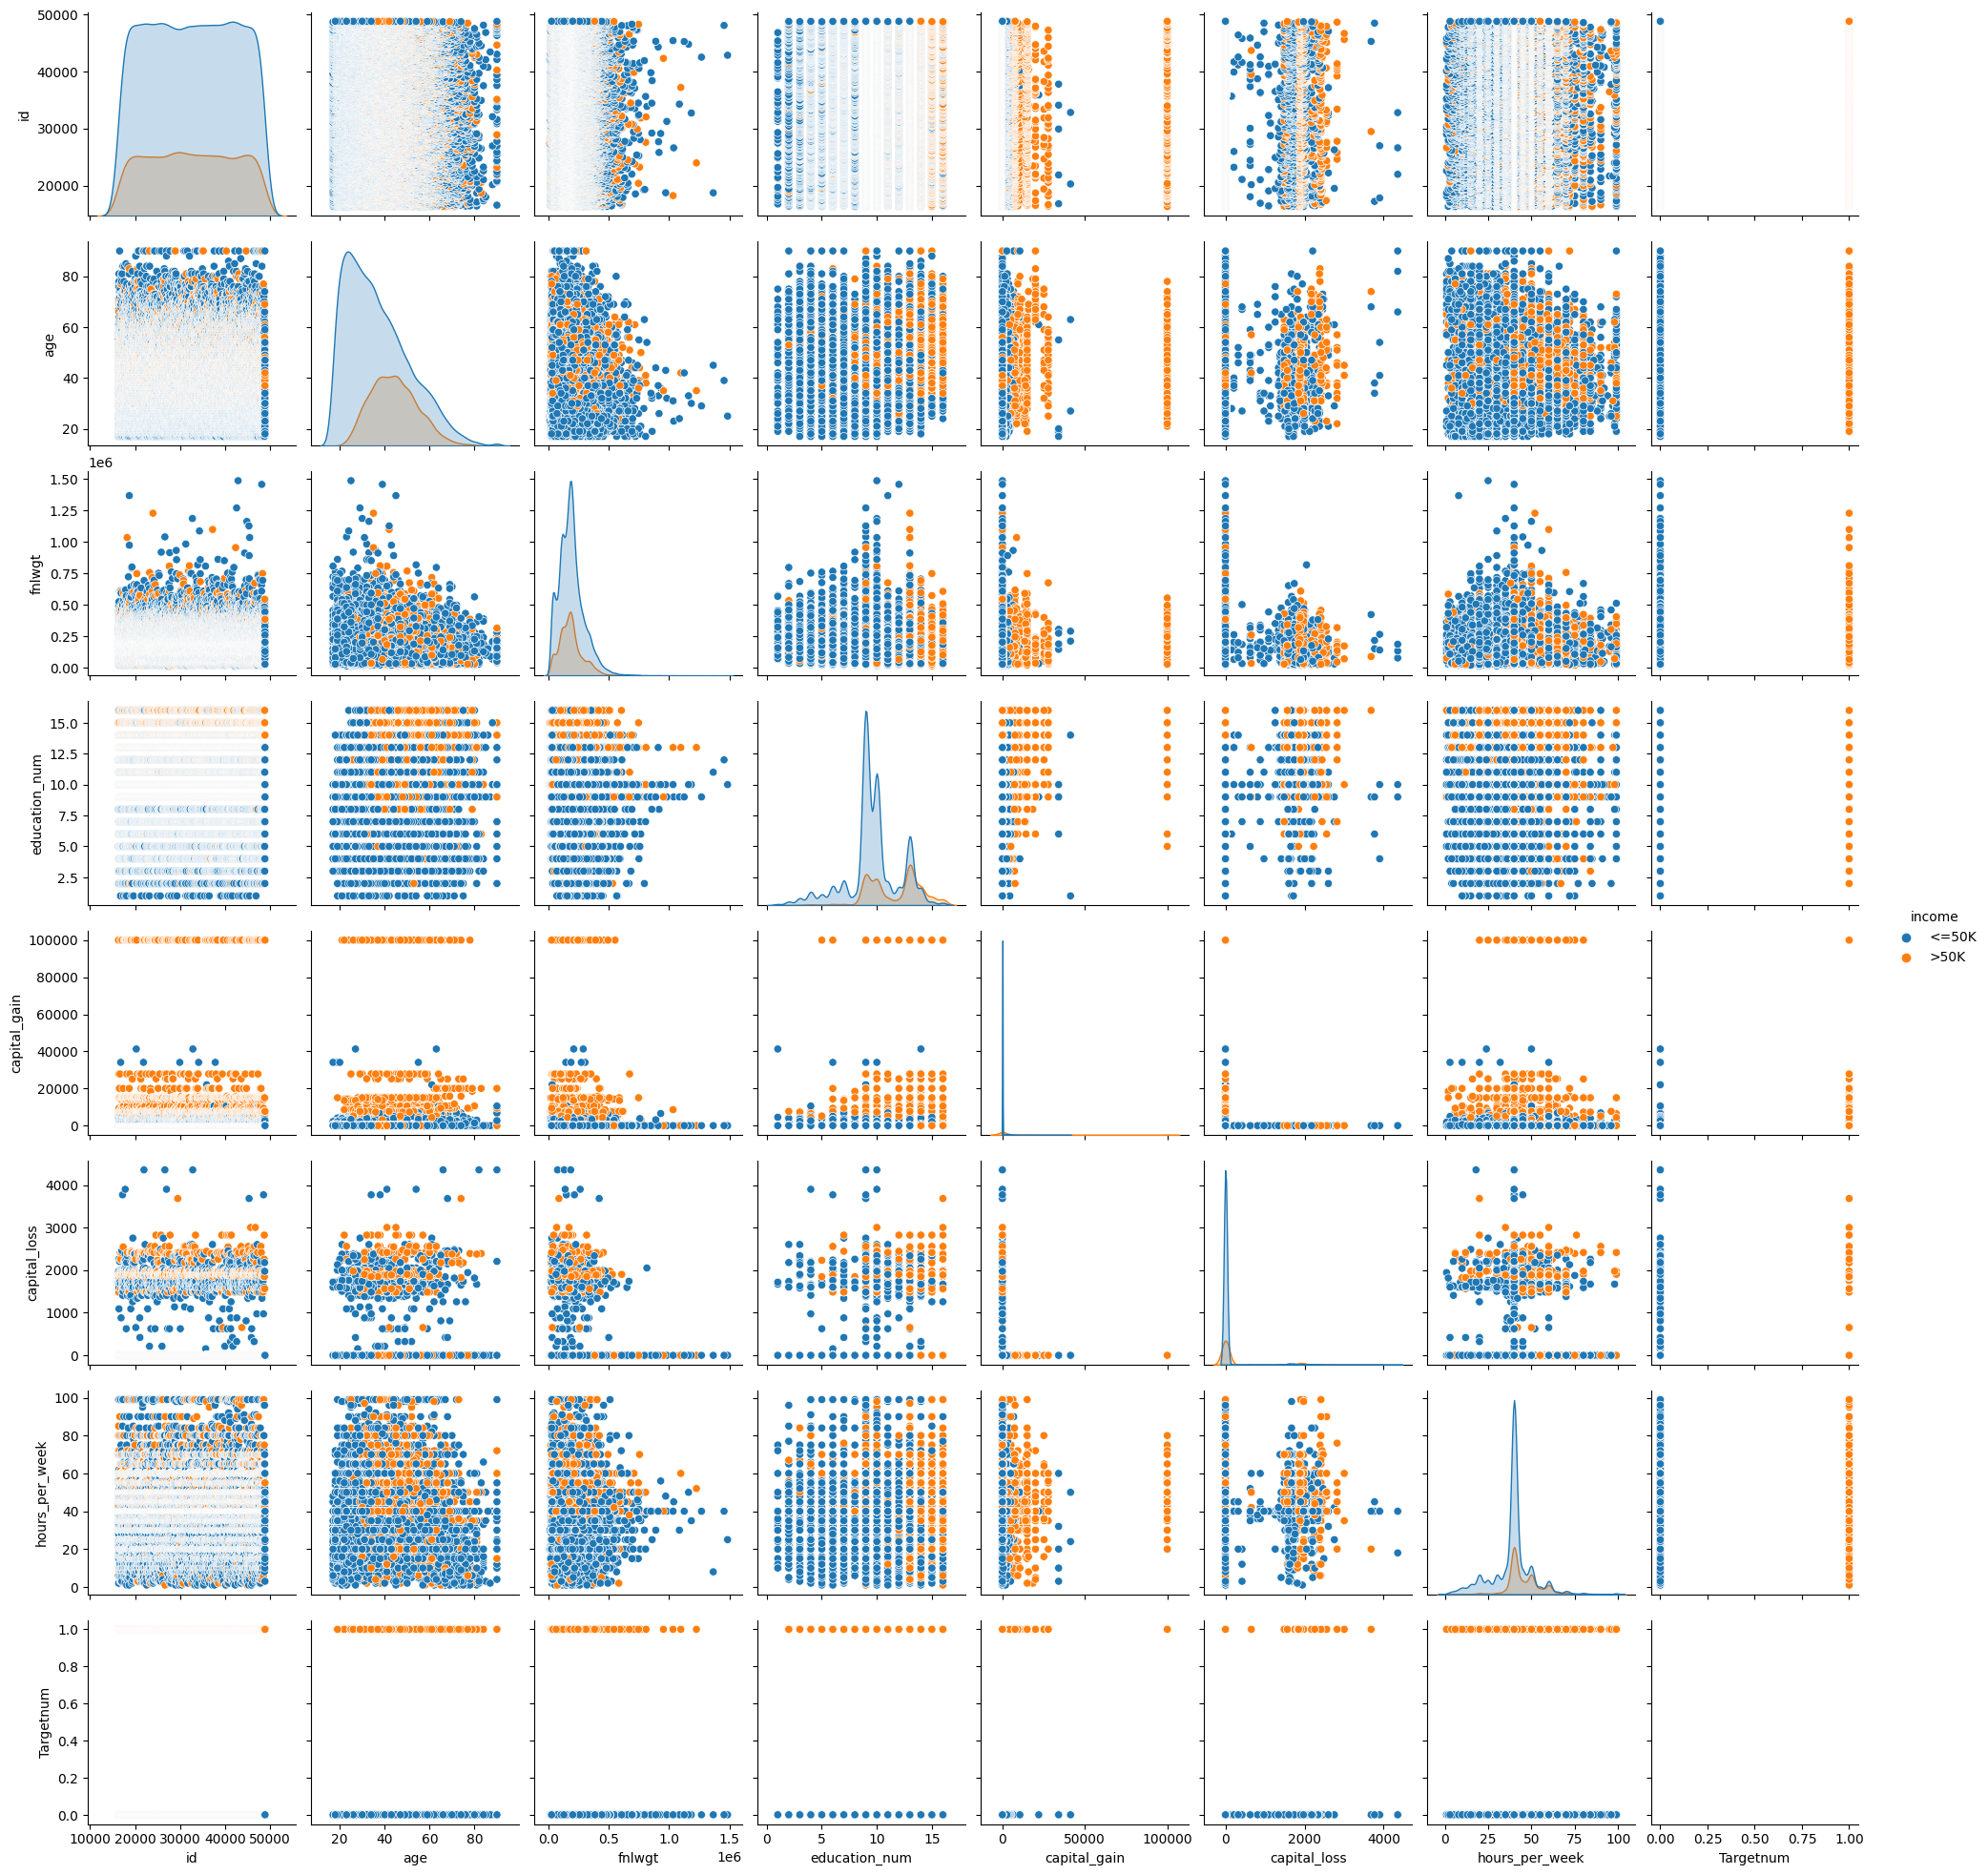

In [11]:
_ = sns.pairplot(data=df_viz, hue="income", diag_kind="kde")
plt.show()

We start by taking a look at the *income* variable

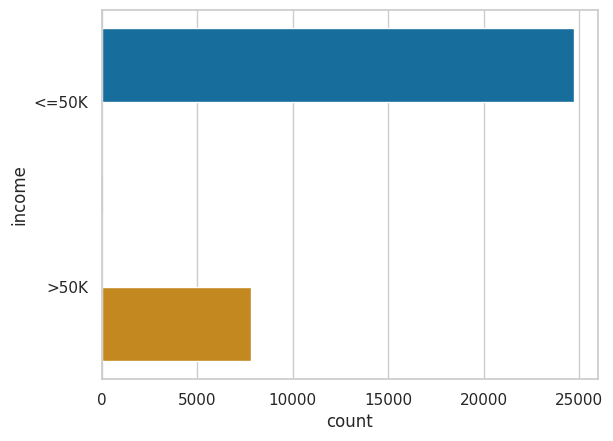

In [13]:
sns.set(style="whitegrid")
sns.countplot(data=df_viz, y='income', hue='income', palette='colorblind')
plt.legend([], [], frameon=False)  # This line removes the legend
plt.show()

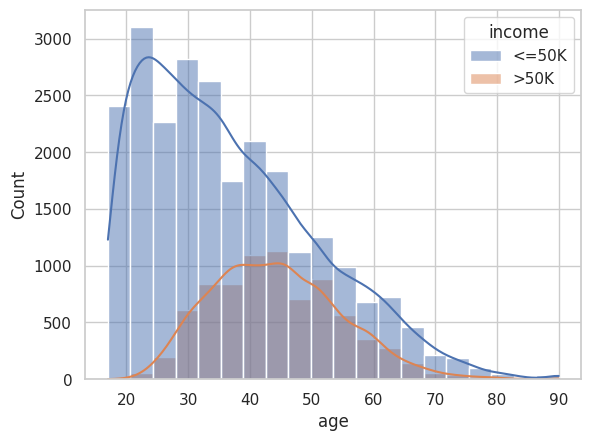

In [14]:
df_viz['income_num'] = LabelEncoder().fit_transform(df_viz['income'])
sns.histplot(data=df_viz, x='age', hue='income', bins=20, kde=True)
plt.show()

It appears that people with incomes above 50k dollars per year have a more uniform age distribution, with a slight bias towards the younger age groups. Those who earn less than 50k dollars per year tend to be concentrated in younger ages, showing a greater frequency in these age groups.

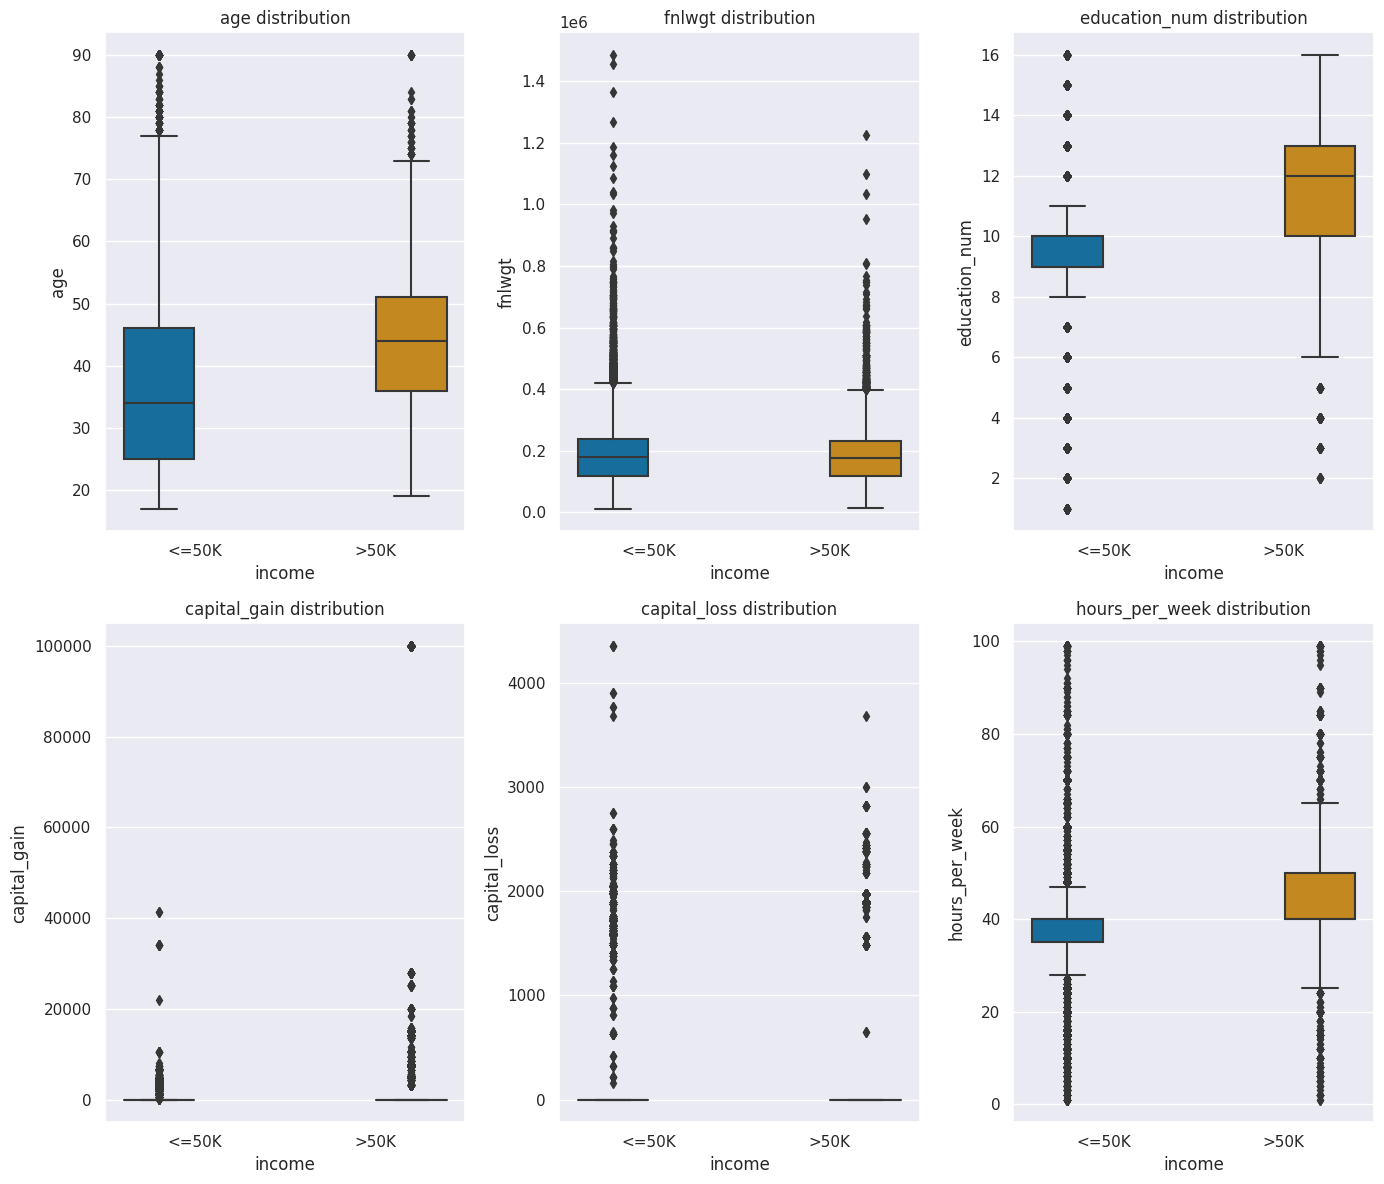

In [19]:
sns.set_style("darkgrid")
flatui = ["#95a5a6", "#34495e"]

names = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 12))

for name, ax in zip(names, axes.flatten()):
    sns.boxplot(x="income", y=name, data=df_viz, orient='v', ax=ax, hue="income", palette="colorblind")
    ax.set_title(f"{name} distribution")
    ax.get_legend().remove()  # This line removes the legend
plt.tight_layout()
plt.show()

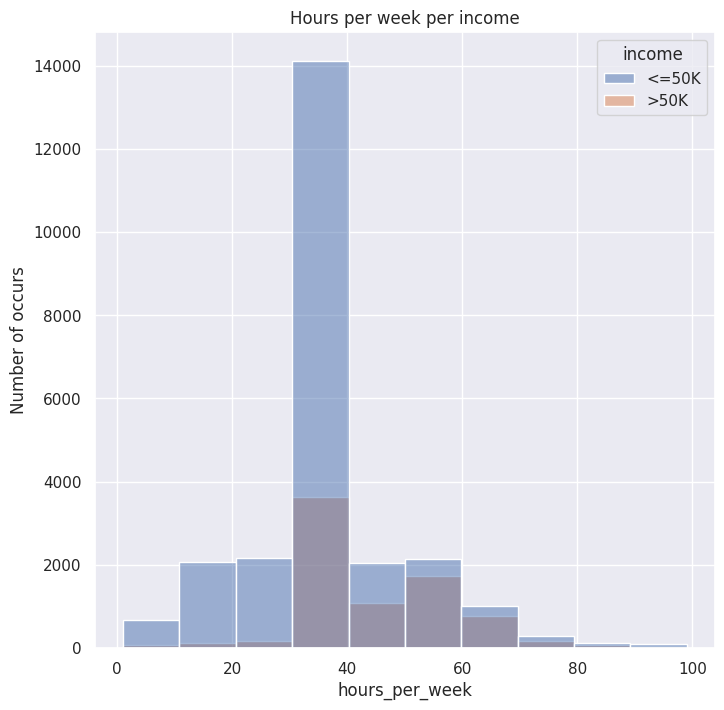

In [20]:
plt.figure(figsize=(8,8))
sns.histplot(data=df_viz, x='hours_per_week', hue='income', bins=10)
plt.ylabel('Number of occurs')
plt.title('Hours per week per income')
plt.show()

People who work a greater number of hours per week tend to receive more than 50k.

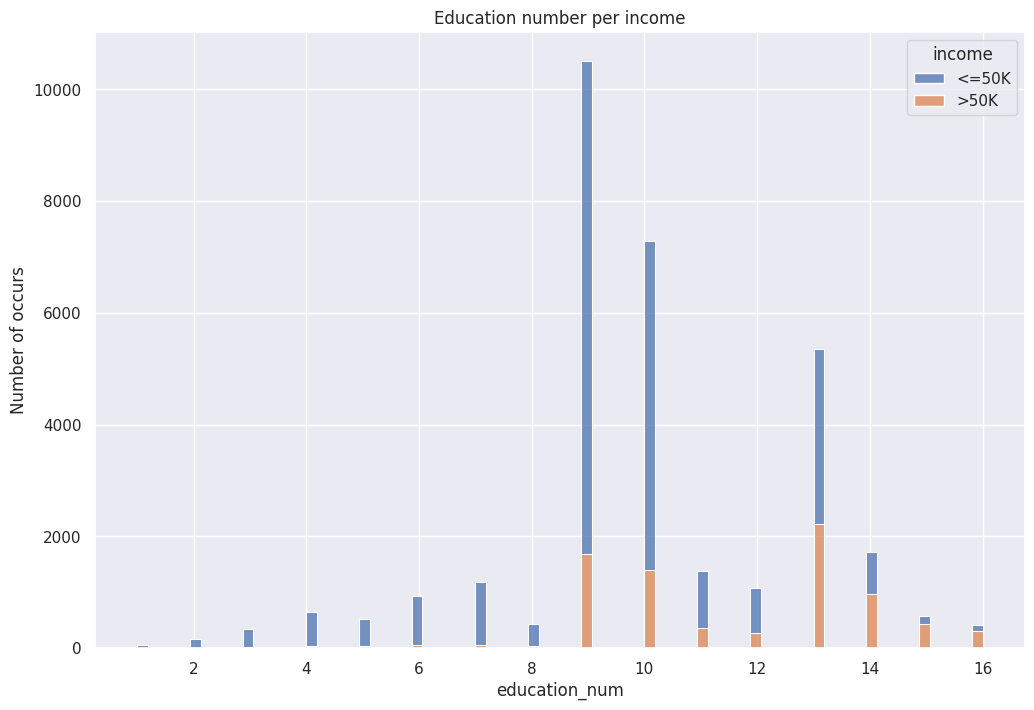

In [21]:
plt.figure(figsize=(12,8))
sns.histplot(data=df_viz, x="education_num", hue='income', multiple="stack")
plt.ylabel('Number of occurs')
plt.title('Education number per income')
plt.show()

Analyzing the graph that shows the number of occurrences in relation to the level of education, we can observe a trend: those with higher levels of education are more likely to receive a salary greater than 50 thousand.

It is noted that most people have an "education_num" value between 8 and 10, regardless of income group (above or below 50 thousand). However, the proportion of people with an education level above 10 is significantly higher in the group with income above 50 thousand. Furthermore, the overwhelming majority of people with incomes above 50 thousand have an education level above level 8.

Now, analyzing more carefully the variables "capital_gain" and "capital_loss"

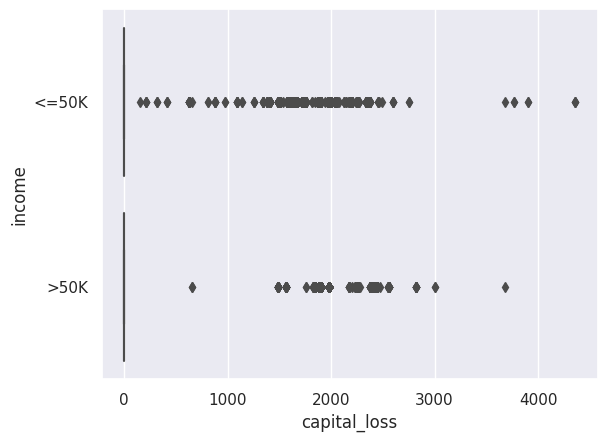

In [22]:
sns.boxplot(data=df_viz, x='capital_loss', y='income')
plt.show()

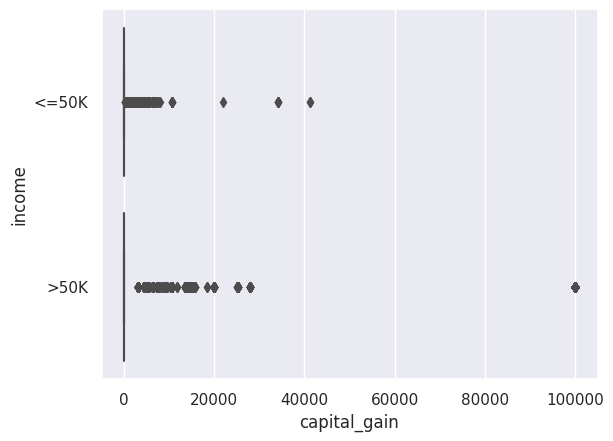

In [23]:
sns.boxplot(data=df_viz, x='capital_gain', y='income')
plt.show()

In [24]:
#Quantidade de valores iguais a zeros para a variável "capital_gain"
zeros = df_viz['capital_gain'].value_counts().get(0, 0)
zeros

29849

In [25]:
#Quantidade de valores iguais a zeros para a variável "capital_loss"
zeros = df_viz['capital_loss'].value_counts().get(0, 0)
zeros

31041

Both the capital_gain and capital_loss variables have a highly skewed distribution, with outliers extremely higher than the rest of the distribution.
Altogether, it is possible to notice, when looking at the dataset, that more than 70% of the individuals in the dataset have both values of these variables equal to 0.0.

This means that these variables may not have good relevance for a classification model.

##### - Analysis by Gender:

In [26]:
gender = df_viz.groupby(['sex','income']).size().reset_index().pivot(columns='income', index='sex', values=0)
gender

income,<=50K,>50K
sex,,
Female,9592,1179
Male,15127,6662


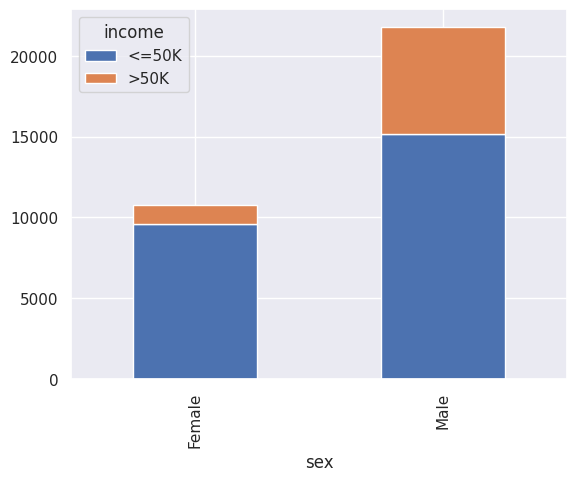

In [28]:
gender.plot(kind='bar', stacked=True)
plt.show()

There is a greater proportion of men than women in the Dataset and, therefore, in the data set, men have a higher proportion of people with more than 50K earnings than women.

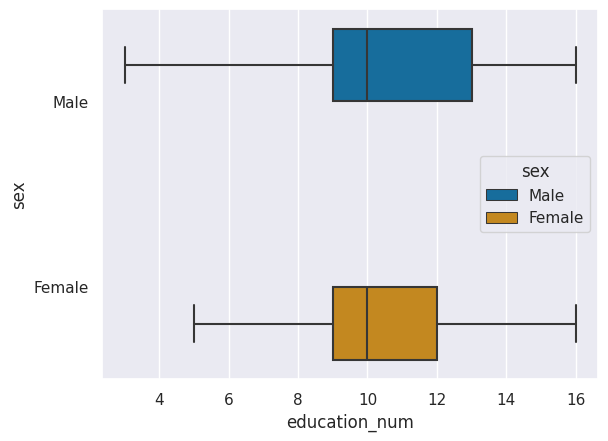

In [29]:
sns.boxplot(data=df_viz, x='education_num', y='sex', hue='sex', palette="colorblind", showfliers=False)
plt.show()

Another relevant factor is that women's level of education presented a distribution more centered around the mean, with a lower standard deviation, while in men, this variable is more dispersed and with asymmetry towards lower levels of education.

##### - Analysis by Ethnicity:

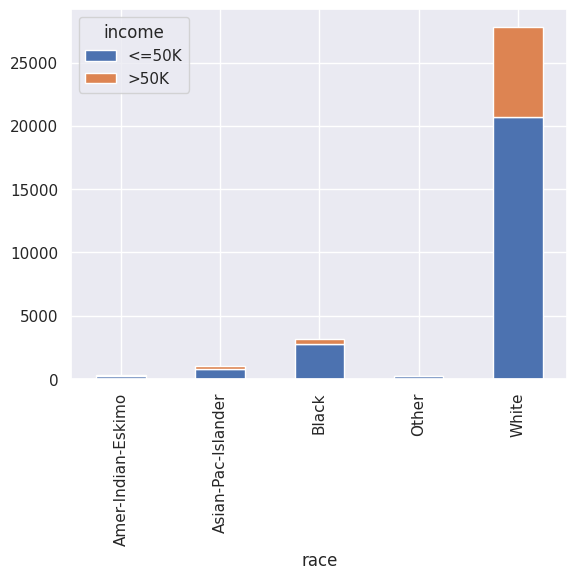

In [30]:
df_viz.groupby(['race','income']).size().reset_index().pivot(columns='income', index='race', values=0).plot(kind='bar', stacked=True)
plt.show()

For a visualization in terms of people referred to as "white" and other ethnicities", let's do some manipulations:

- **Replacement of Null Values**: Null values are replaced by the variable's Mode value = "White".
- **New Variable**: "race_thread" is created to store information
- **Others**: In the "race_thread" variable, ethnicities other than "white" are changed to "others"

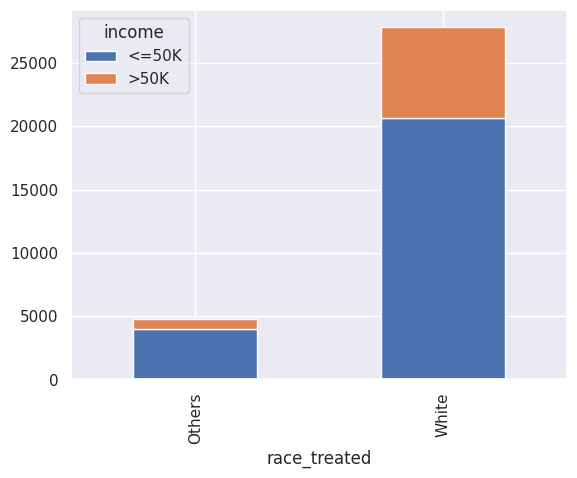

In [31]:
df_viz['race_treated'] = df_viz['race'].fillna(df_viz['race'].value_counts().index[0])
df_viz.loc[df_viz['race_treated'] != 'White','race_treated'] = 'Others'
df_viz.groupby(['race_treated','income']).size().reset_index().pivot(columns='income', index='race_treated', values=0).plot(kind='bar', stacked=True)
plt.show()

This way, the resulting graph will show how the income distribution (above or below 50K) varies between the 'White' and 'Others' categories.

The graph shows us that there is a significantly higher number of white people compared to other ethnicities and these "White" people have a higher proportion of people who earn above 50K than other ethnicities.

##### - Additional analyses:

Looking at the Dataset variables, it is possible to observe that there are two columns that appear to convey similar information, namely: *"education"* and *"education_num"*, so it is worth investigating and comparing the contents of both.

In [32]:
df_viz.groupby(['education','education_num']).size().reset_index().sort_values('education_num').rename(columns={0:'Qtd.'})

,education,education_num,Qtd.
13,Preschool,1,51
3,1st-4th,2,168
4,5th-6th,3,333
5,7th-8th,4,646
6,9th,5,514
0,10th,6,933
1,11th,7,1175
2,12th,8,433
11,HS-grad,9,10501
15,Some-college,10,7291


With this table we see that, in fact, the information in both columns is redundant as they present the same information.
Therefore, for the model, it will be chosen to use the variable *education_num* as the data is numerical and ordered by level of education.

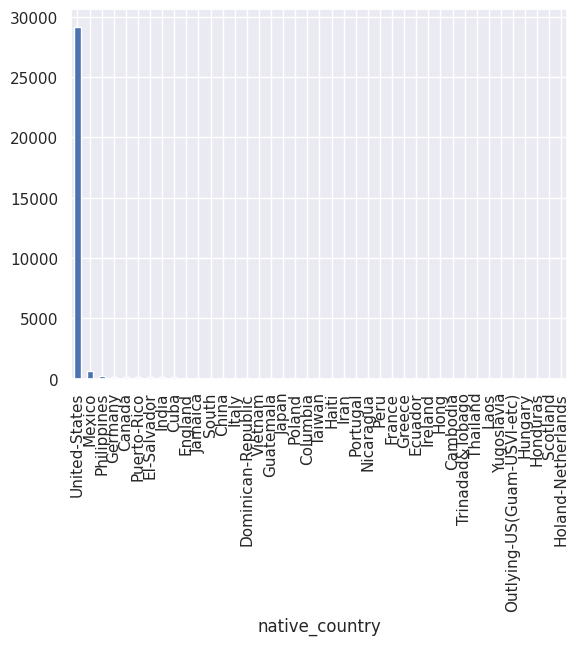

In [33]:
df_viz.native_country.value_counts().plot(kind="bar")
plt.show()

As was the case with the ethnicity variable, divided into "white" and "others", as the proportion of individuals from the United States is extremely higher than the rest, this variable will be replaced by a binary class between native to the USA or not.

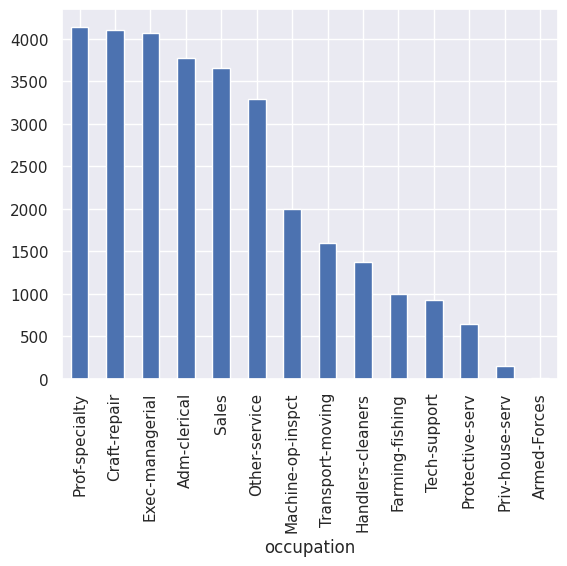

In [34]:
df_viz.occupation.value_counts().plot(kind="bar")
plt.show()

With this graph we see that:

- Adults in executive roles are equally likely to earn more than $50,000 per year.

- There is a probability of close to 33% for an adult in specialized professions to earn more than 50 thousand dollars per year.

- Adults working in Agriculture-Fishing, Machinery Operation and Inspection, Other Services, Administrative Clerks, and Transportation-Moving have a very low probability of earning more than $50,000 per year.

- Approximately 25% of people who work in Sales earn more than 50 thousand dollars per year.


## 2. Data Preparation

The following code is converting categorical variables to numeric values using Label Encoder. This is done for both the training set (top) and the testing set (bottom).

Categorical variables, such as "workclass," "education," "marital_status," "occupation," "relationship," "race," "sex," "native_country," "age," and "education_num," are mapped to values numeric so that they can be used in machine learning algorithms, which generally require numeric inputs

In [35]:
#Train Dataset
categorical_features_train = ["workclass", "education", "marital_status","occupation", "relationship", "race", "sex", "native_country","age","education_num"]
label_encoder_feat = {}
for i, feature in enumerate(categorical_features_train):
    label_encoder_feat[feature] = LabelEncoder()
    df_train[feature] = label_encoder_feat[feature].fit_transform(df_train[feature])
    
#Test Dataset
categorical_features_test = ["workclass", "education", "marital_status","occupation", "relationship", "race", "sex", "native_country","age","education_num"]
label_encoder_feat = {}
for i, feature in enumerate(categorical_features_test):
    label_encoder_feat[feature] = LabelEncoder()
    df_test[feature] = label_encoder_feat[feature].fit_transform(df_test[feature])

## 3. Modeling

### 3.1 Features Selection

The following code performs a selection of the best features from a data set. It uses scikit-learn's "SelectKBest" method, employing the chi-square score ("chi2") as the scoring metric. The variable "ft" stores the selected characteristics, and the value "k = 'all'" indicates that all characteristics must be considered.

In essence, this helps identify which features have the greatest relevance or discriminatory power in relation to the target variable ("Income") in the data.

In [36]:
ft = SelectKBest(chi2, k = "all").fit(df_train.drop(labels = ["income"], axis = 1), df_train.income)
print('Score: ', ft.scores_)
print('Columns: ', df_train.columns)

Score:  [4.82081387e+01 1.53781675e+04 7.32679808e+01 1.71812389e+05
 2.97900431e+02 2.66624031e+03 1.12331938e+03 1.10321534e+01
 3.65928424e+03 3.30379810e+01 5.02508527e+02 8.21977263e+07
 1.37204879e+06 6.47643538e+03 1.77179697e+01]
Columns:  Index(['id', 'age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')


### 4.2 Data Separation

Separating the data from the training dataset into training data and using part of it (20% -> "test_size" parameter) as test data.

In [37]:
features_ = df_train[["age", "education","occupation", "relationship", "sex", "capital_gain", "capital_loss", "hours_per_week"]]
target = df_train['income']
X_train, X_test_split, y_train, y_test_split = train_test_split(features_, target, test_size = 0.2,random_state = 0)

print ("Train data set size : ", X_train.shape)
print ("Test data set size : ", X_test_split.shape)

Train data set size :  (26048, 8)
Test data set size :  (6512, 8)


### 4.3 Model Training

Firstly, it is necessary to optimize the hyperparameters for a k-Nearest Neighbors (k-NN) classifier using the Grid Search technique.

The hyperparameters under consideration are the number of neighbors (n_neighbors), the type of weight to be assigned to neighbors (weights), and the distance metric (metric) used to calculate the proximity between points.

In [38]:
grid_params = { 'n_neighbors' : [11,12,13,14,15,16,17,18,19,20,21,23,25],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan'],}

Utilizamos a classe GridSearchCV do scikit-learn para realizar uma pesquisa exaustiva sobre todas as combinações desses hiperparâmetros, avaliando o desempenho do modelo k-NN com validação cruzada e paralelizando o processo com múltiplos trabalhadores.

In [39]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)

Then we do model training.

In [40]:
model = gs.fit(X_train,y_train)

Fitting 3 folds for each of 78 candidates, totalling 234 fits


After adjusting the model to the training data (X_train and y_train), we sought to find the best score obtained in cross validation (model.best_score_) and the hyperparameters that produced this best performance (model.best_params_)

In [41]:
model.best_score_

0.8472819140515657

In [42]:
model.best_params_

{'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'uniform'}

Now, a brief explanation of the output data:

- **metric**: 'manhattan': This indicates that the best value for the metric hyperparameter is 'manhattan'. In the context of the k-Nearest Neighbors (k-NN) algorithm, metric generally refers to the distance metric used to measure the proximity between points. The 'manhattan' metric refers to the distance from Manhattan, which is the sum of the absolute differences between the coordinates of points. It is a common distance metric in k-NN.

- **'n_neighbors'**: This indicates that the best value for the n_neighbors hyperparameter is 14. The n_neighbors specifies the number of nearest neighbors that the k-NN algorithm will take into account when making a prediction. In your case, the ideal value found was 14.

- **'weights'**: This indicates that the best value for the weights hyperparameter is 'uniform'. The weights determines how neighbors are weighted when making a prediction. In the case of 'uniform', all neighbors have the same weight, which means that each neighbor contributes equally to the final decision.

## 4.4 Model Evaluation

Next, a k-Nearest Neighbors (k-NN) classifier is created using the hyperparameter values found previously: metric = manhattan, n_neighbors=16 and weights=uniform.

The k-NN model is trained with the training data. X_train contains the characteristics (attributes) of the training examples, and y_train contains the labels (values you want to predict) corresponding to the training examples.

In [43]:
knn = KNeighborsClassifier(n_neighbors = 16, weights = 'uniform',metric = 'manhattan')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=16)

The trained model is used to make predictions on the test data (represented by X_test_split)

In [44]:
Y_test = knn.predict(X_test_split)

In [45]:
print("Confusion Matrix:")
print(confusion_matrix(y_test_split,Y_test))

Confusion Matrix:
[[4585  269]
 [ 771  887]]


Displaying the results

In [46]:
print('Test set accuracy score: ', accuracy_score(y_test_split,Y_test))
print('Test set precision score: ', precision_score(y_test_split,Y_test,pos_label= "<=50K"))
print('Test set recall score: ', recall_score(y_test_split,Y_test,pos_label= "<=50K"))
print('Test set f1 score: ', f1_score(y_test_split,Y_test,pos_label= "<=50K"))

Test set accuracy score:  0.8402948402948403
Test set precision score:  0.85604929051531
Test set recall score:  0.9445817882159044
Test set f1 score:  0.8981390793339863


In [47]:
print(classification_report(y_test_split,Y_test))

              precision    recall  f1-score   support

       <=50K       0.86      0.94      0.90      4854
        >50K       0.77      0.53      0.63      1658

    accuracy                           0.84      6512
   macro avg       0.81      0.74      0.76      6512
weighted avg       0.83      0.84      0.83      6512



In [48]:
scores = cross_val_score(knn, X_test_split, y_test_split, cv=10)
print("Scores: ", scores)
print('Model accuracy: ', np.mean(scores))

Scores:  [0.80981595 0.81595092 0.81259601 0.82488479 0.82795699 0.85253456
 0.83870968 0.8156682  0.83870968 0.82334869]
Model accuracy:  0.8260175473316181


The code above performs a comprehensive evaluation of the performance of a K-Nearest Neighbors (knn) classification model on the test set. This is done through a process called cross-validation, in which the test set is divided into 10 parts (folds). The knn model is then repeatedly trained and tested on each of these folds. The scores resulting from each run are collected in a list called "scores".

The code then prints the individual scores for each fold, allowing detailed evaluation of performance across different subdivisions of the test set. Finally, it averages these scores and prints them as the "model accuracy", providing an overall estimate of how well the knn model is performing on the test set

## 4. Submission

Saving the Results

In [49]:
knn = KNeighborsClassifier(n_neighbors = 16, weights = 'uniform',metric = 'manhattan')

#Final Model
X = df_train[["age", "education", "relationship", "sex", "capital_gain", "capital_loss", "hours_per_week", "occupation"]]
Y = df_train["income"]
knn.fit(X, Y)


X_test = df_test[["age", "education", "relationship", "sex", "capital_gain", "capital_loss", "hours_per_week", "occupation"]]
Y_test = knn.predict(X_test)

In [50]:
#Saving the results for final model
submission = pd.DataFrame({'income': Y_test})
submission.index.name = 'id'
submission.to_csv('submission.csv')
submission.head()

,income
id,
0,<=50K
1,>50K
2,<=50K
3,<=50K
4,>50K


And That's it!